# Overview of the `poligrain` package
simplify common tasks for working with point, line and gridded rainfall sensor data

#### The common tasks are:
* **Plot data on a map**
* **Compare line and grid data**
* **Calculate distances between points, lines and grids and find nearest neighbors**
* **Validate and compare different datasets**

In [ ]:
import sys

sys.path.append('../poligrain/src')

In [ ]:
import matplotlib.pyplot as plt
import poligrain as plg

## Get OpenMRG example data

<img src="https://essd.copernicus.org/articles/14/5411/2022/essd-14-5411-2022-f02-web.png" alt="drawing" width="300"/>


We download a subset of the OpenMRG dataset which is described in Andersson et al. (2022) here https://doi.org/10.5194/essd-14-5411-2022 and which is available for download at https://doi.org/10.5281/zenodo.6673750

The subset that we use was already processed, in particular the CML data, but with a very basic processing.

In addition, here, we will project the lon-lat coordinates in the fitting UTM zone, so that we can do correct distance calculations.

In [ ]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data")

### Project coordinates to UTM

In [ ]:
# Project coordinates for rain gauges
ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, "EPSG:25832"
)
ds_gauge_smhi.coords["x"], ds_gauge_smhi.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauge_smhi.lon, ds_gauge_smhi.lat, "EPSG:25832"
)

# Project coordinates for CMLs
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, "EPSG:25832"
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, "EPSG:25832"
)

# Project coordinates of radar
(
    ds_rad.coords["x_grid"],
    ds_rad.coords["y_grid"],
) = plg.spatial.project_point_coordinates(
    ds_rad.lon,
    ds_rad.lat,
    "EPSG:25832",
)

## Intro to data model

In OPENSENSE we agreed on a specific structure and naming convention for storing data in NetCDF([Fencl et al. (2024)](https://doi.org/10.12688/openreseurope.16068.2)), which translates to the respective `xarray.Dataset` objects.

### CML data

In [ ]:
ds_cmls

### Gauge data

In [ ]:
ds_gauges_municp

###  Radar data (on cartesian grid)

In [ ]:
ds_rad

## Plot data on a map

Because plotting lines with a colormap is not as easy as plotting points or gridded data, `poligrain` provides plotting functions that deal with the line geometry. Because we assume a fixed structure and naming convention of our `xarray.Dataset` we can do a lot of cumbersome stuff inside the function. See it in action below.

CML rain rates for a selected time stamp

In [ ]:
da_R = ds_cmls.R.isel(sublink_id=0).sel(time='2015-07-25 10:00:00')

fig, ax = plt.subplots(figsize=(5, 4))
lines = da_R.plg.plot_cmls(pad_width=1, vmin=0, vmax=5, ax=ax, use_lon_lat=True)
plt.colorbar(lines, label="rainfall rate in mm/h");

Rainfall sums over full period for radar, CMLs and gauges

In [ ]:
# Aggregate to hourly rainfall
cmls_R_1h = ds_cmls.R.isel(sublink_id=0).resample(time='1h').mean()

In [ ]:
plg.plot_map.plot_plg(
    da_grid = ds_rad.R.resample(time='1h').mean().sum(dim="time"),
    da_gauges = ds_gauges_municp.rainfall_amount.sum(dim="time"),
    da_cmls = cmls_R_1h.sum(dim="time"),
    use_lon_lat = True,
    vmin = 0,
    vmax = 100,
)

## Extract radar along CML paths and compare data

Similar to the `wradlib.adjust.RawAtObs` we provide functions to get data of a grid at specific points using `plg.spatial.GridAtPoints`. Since we also deal with line geometries of the CMLs (and also SMls) we provide `GridAtLines` to extract the path-averaged grid values along the intersection with a specific line.

In [ ]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_rad,
    ds_line_data=ds_cmls,
)

In [ ]:
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_rad.R)

In [ ]:
radar_along_cml

Aggregate reference to hourly rainfall for comparison

In [ ]:
radar_along_cml_R_1h = radar_along_cml.resample(time='1h').mean()

In [ ]:
cml_id = 10030

cmls_R_1h.sel(cml_id=cml_id).plot(color='k', figsize=(12, 5), label='CML')
radar_along_cml_R_1h.sel(cml_id=cml_id).plot(color='r', label='radar')
plt.legend()
plt.ylabel('hourly rainfall sum (mm)');

Plot path-averaged radar rain rates for each CML and the processed CML rain rates

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plg.plot_map.plot_plg(
    da_cmls=radar_along_cml_R_1h.sum(dim='time'), 
    ax=axs[0], 
    vmin=0, 
    vmax=100,
)
axs[0].set_title('Radar at CMLs rainfall sum')

plg.plot_map.plot_plg(
    da_cmls=cmls_R_1h.sum(dim='time'), 
    ax=axs[1],
    vmin=0,
    vmax=100,
)
axs[1].set_title('CML rainfall sum');

## Excercise 1: Analyse difference between radar and CML

- 1.1: Calculate the difference between radar and CML rainfall sums. Plot this difference as a map using `plg.plot_map.plot_plg`

- 1.2 (optional): What is wrong with the outliers of the CMLs?

### Exercise 1.1

In [ ]:
# Write code here...







In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load solutions/1_1_1_solution.py

### Exercise 1.2

In [ ]:
# Write code here...







In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load solutions/1_1_2_solution.py

## Find gauges close to CMLs and compare data

`poligrain` provides functions to find the closest points (gauges in this case) to a line (CMLs). Getting closest points for a point is also supported via `plg.spatial.get_closest_points_to_point`.

In [ ]:
max_distance = 2000  # in meters due to the projection EPSG:25832
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cmls, ds_gauges_municp, max_distance=max_distance, n_closest=10
)

In [ ]:
closest_neigbors

Plot distance of closest neighour for some CMLs

In [ ]:
closest_neigbors.isel(cml_id=slice(0, 60)).distance.plot();

Plot closest gauges for a CML on the map

In [ ]:
# plot CMLs and gauges on map and highlight those that are closer than 5000m
cml_id = 10030

# hacky way to get bool array with closest gauges set to True
da_gauges_close = (ds_gauges_municp.id == closest_neigbors.neighbor_id.sel(cml_id=cml_id)).max(dim='n_closest')

fig, ax = plt.subplots()
plg.plot_map.plot_lines(ds_cmls, line_color='k', ax=ax)
plg.plot_map.plot_lines(ds_cmls.sel(cml_id=cml_id), line_color='r', line_width=2, ax=ax)
# hacky way to plot the gauges highligting the close ones
plg.plot_map.plot_plg(da_gauges=da_gauges_close, ax=ax, vmin=0, vmax=2, cmap='Reds')


Plot rainfall time series for CML and closest gauges

In [ ]:
cml_id = 10030
ds_closests_gauges = (
    ds_gauges_municp.sel(id=closest_neigbors.sel(cml_id=cml_id).neighbor_id.values[:3])
)
ds_closests_gauges.rainfall_amount.resample(time='1h').sum().plot.line(x='time', figsize=(12, 5))
ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.resample(time='1h').mean().plot(color='k')
plt.ylabel('hourly rainfall sum (mm)');

Let's zoom in and plot the data with the original temporal resolution

In [ ]:
cml_id = 10030
ds_closests_gauges = (
    ds_gauges_municp.sel(id=closest_neigbors.sel(cml_id=cml_id).neighbor_id.values[:3])
)
(ds_closests_gauges.sel(time='2015-07-25').rainfall_amount * 60).plot.line(x='time', figsize=(12, 5))
ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id, time='2015-07-25').R.plot(color='k')
plt.ylabel('rain rate (mm/h)');

If we aggregate the gauge to 5-minute rain rates we some more dynamics in the gauge data.

In [ ]:
cml_id = 10030
ds_closests_gauges = (
    ds_gauges_municp.sel(id=closest_neigbors.sel(cml_id=cml_id).neighbor_id.values[:3])
)
(ds_closests_gauges.sel(time='2015-07-25').rainfall_amount.resample(time='5min').sum() * 12).plot.line(x='time', figsize=(12, 5))
ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id, time='2015-07-25').R.plot(color='k')
plt.ylabel('rain rate (mm/h)');

## Excercise 2 (optional): Compare CML to gauges within 2 km

- Exercise 2.1: Do a scatter plot of of the 1-hour rainfall amounts from the closest gauge to each CML.

- Exercise 2.2: Add the radar at the CML to the scatter plot

The following code gives you, for each CML, the ID of the closest gauge if there is a gauge within 2 km range from the CML path.

Note that CMLs with no gauge withon 2km have been dropped here. Hence, the length of `gauge_id_closest` and `closest_neigbors` is different in the `cml_id` dimension.

In [ ]:
gauge_id_closest = closest_neigbors.neighbor_id.where(closest_neigbors.distance < 2000, drop=True).isel(n_closest=0)
gauge_id_closest

### Exercise 2.1

In [ ]:
# Write code here...






In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load solutions/1_2_1_solution.py

### Exercise 2.2

In [ ]:
# Write code here...






In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load solutions/1_2_2_solution.py

## Validation metrics and plots 

`poligrain` provides plots and the calculation of standard metrics for validating the results. In particular the options for validating rain event detection are quite unique (probably because this very important for CML data processing and less important for radars ans gauges).

In [ ]:
radar_along_cml_R_1h = radar_along_cml.resample(time='1h').mean().transpose()
R_cml_1h = ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean()

In [ ]:
R_threshold = 0.1

plg.validation.plot_hexbin(
    radar_along_cml_R_1h.data.flatten(),
    R_cml_1h.data.flatten(),
    ref_thresh=R_threshold,
    est_thresh=R_threshold,
)

In [ ]:
rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=radar_along_cml_R_1h.data.flatten(),
    estimate=R_cml_1h.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
)
rainfall_metrics

In [ ]:
plg.validation.plot_confusion_matrix_count(
    reference=radar_along_cml_R_1h.data.flatten(),
    estimate=R_cml_1h.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    n_bins=1000,
    bin_type='linear',
);
#plt.gca().set_xscale("linear")
#plt.gca().set_yscale("log")
plt.xlim([0.09, 10])

In [ ]:
plg.validation.plot_confusion_matrix_sum(
    reference=radar_along_cml_R_1h.data.flatten(),
    estimate=R_cml_1h.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    n_bins=1000,
    bin_type='linear',
    time_interval=60,
);
#plt.gca().set_xscale("linear")
#plt.gca().set_yscale("log")
plt.xlim([0.09, 10])

## Other example datasets

### OpenRainER

CML, gauge and radar data from Emiliga Romana (Italy)

Available at https://zenodo.org/records/14731404 

Some info from the OPENSENSE news page: https://opensenseaction.eu/news/new-open-cml-dataset-from-italy-openrainer/


<img src="https://opensenseaction.eu/wp-content/uploads/2024/03/OpenRainER.jpg" alt="drawing" width="600"/>


In [ ]:
(
    ds_rad,
    ds_cmls,
    ds_gauges
) = plg.example_data.load_openrainer(data_dir="example_data", subset='8d')

In [ ]:
plg.plot_map.plot_lines(ds_cmls.rsl.isel(sublink_id=0).std(dim='time'), vmin=0, vmax=5)

In [ ]:
ds_cmls.isel(cml_id=0).rsl.plot.line(x='time', figsize=(12, 3));

### Amsterdam PWS dataset
PWS data from ~130 PWS over more than two years, together with reference gauge data.  
Available from: 

In [6]:
(
    ds_pws,
    ds_gauges,
) = plg.example_data.load_ams_pws(data_dir="example_data", subset="full_period")

File already exists at example_data/ams_pws_full_period.nc
Not downloading!
File already exists at example_data/ams_gauges_full_period.nc
Not downloading!


In [9]:
ds_pws

<xarray.Dataset> Size: 237MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) float64 1kB ...
    lat        (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon        (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
Data variables:
    rainfall   (id, time) float64 235MB ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

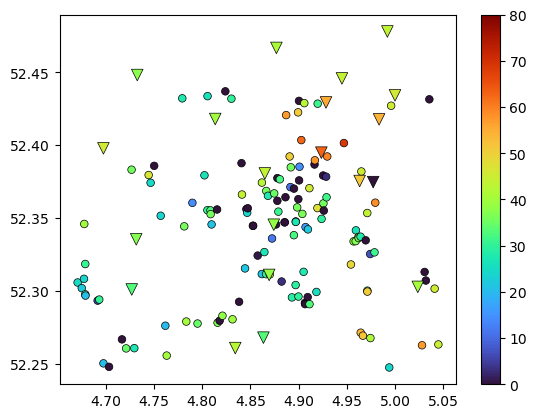

In [11]:
fig, ax = plt.subplots()
pws_plot = plg.plot_map.plot_plg(
    da_gauges=ds_pws.sel(time="2018-05").rainfall.sum(dim="time"),
    vmin=0,
    vmax=80,
    kwargs_gauges_plot={
        "s": 30,
        "label": "PWS",
    },
    ax=ax,
)
gauge_plot = plg.plot_map.plot_plg(
    da_gauges=ds_gauges.sel(time="2018-05").rainfall.sum(dim="time"),
    vmin=0,
    vmax=80,
    kwargs_gauges_plot={
        "s": 70,
        "marker": "v",
        "label": "reference gauges",
    },
    ax=ax,
    add_colorbar=False
)
